# Introduction to Classification

Written by:
- Manuel Szewc (School of Physics, University of Cincinnati)
- Philip Ilten (School of Physics, University of Cincinnati)
$\renewcommand{\gtrsim}{\raisebox{-2mm}{\hspace{1mm}$\stackrel{>}{\sim}$\hspace{1mm}}}\renewcommand{\lessim}{\raisebox{-2mm}{\hspace{1mm}$\stackrel{<}{\sim}$\hspace{1mm}}}\renewcommand{\as}{\alpha_{\mathrm{s}}}\renewcommand{\aem}{\alpha_{\mathrm{em}}}\renewcommand{\kT}{k_{\perp}}\renewcommand{\pT}{p_{\perp}}\renewcommand{\pTs}{p^2_{\perp}}\renewcommand{\pTe}{\p_{\perp\mrm{evol}}}\renewcommand{\pTse}{\p^2_{\perp\mrm{evol}}}\renewcommand{\pTmin}{p_{\perp\mathrm{min}}}\renewcommand{\pTsmim}{p^2_{\perp\mathrm{min}}}\renewcommand{\pTmax}{p_{\perp\mathrm{max}}}\renewcommand{\pTsmax}{p^2_{\perp\mathrm{max}}}\renewcommand{\pTL}{p_{\perp\mathrm{L}}}\renewcommand{\pTD}{p_{\perp\mathrm{D}}}\renewcommand{\pTA}{p_{\perp\mathrm{A}}}\renewcommand{\pTsL}{p^2_{\perp\mathrm{L}}}\renewcommand{\pTsD}{p^2_{\perp\mathrm{D}}}\renewcommand{\pTsA}{p^2_{\perp\mathrm{A}}}\renewcommand{\pTo}{p_{\perp 0}}\renewcommand{\shat}{\hat{s}}\renewcommand{\a}{{\mathrm a}}\renewcommand{\b}{{\mathrm b}}\renewcommand{\c}{{\mathrm c}}\renewcommand{\d}{{\mathrm d}}\renewcommand{\e}{{\mathrm e}}\renewcommand{\f}{{\mathrm f}}\renewcommand{\g}{{\mathrm g}}\renewcommand{\hrm}{{\mathrm h}}\renewcommand{\lrm}{{\mathrm l}}\renewcommand{\n}{{\mathrm n}}\renewcommand{\p}{{\mathrm p}}\renewcommand{\q}{{\mathrm q}}\renewcommand{\s}{{\mathrm s}}\renewcommand{\t}{{\mathrm t}}\renewcommand{\u}{{\mathrm u}}\renewcommand{\A}{{\mathrm A}}\renewcommand{\B}{{\mathrm B}}\renewcommand{\D}{{\mathrm D}}\renewcommand{\F}{{\mathrm F}}\renewcommand{\H}{{\mathrm H}}\renewcommand{\J}{{\mathrm J}}\renewcommand{\K}{{\mathrm K}}\renewcommand{\L}{{\mathrm L}}\renewcommand{\Q}{{\mathrm Q}}\renewcommand{\R}{{\mathrm R}}\renewcommand{\T}{{\mathrm T}}\renewcommand{\W}{{\mathrm W}}\renewcommand{\Z}{{\mathrm Z}}\renewcommand{\bbar}{\overline{\mathrm b}}\renewcommand{\cbar}{\overline{\mathrm c}}\renewcommand{\dbar}{\overline{\mathrm d}}\renewcommand{\fbar}{\overline{\mathrm f}}\renewcommand{\pbar}{\overline{\mathrm p}}\renewcommand{\qbar}{\overline{\mathrm q}}\renewcommand{\rbar}{\overline{\mathrm{r}}}\renewcommand{\sbar}{\overline{\mathrm s}}\renewcommand{\tbar}{\overline{\mathrm t}}\renewcommand{\ubar}{\overline{\mathrm u}}\renewcommand{\Bbar}{\overline{\mathrm B}}\renewcommand{\Fbar}{\overline{\mathrm F}}\renewcommand{\Qbar}{\overline{\mathrm Q}}\renewcommand{\tms}{{t_{\mathrm{\tiny MS}}}}\renewcommand{\Oas}[1]{{\mathcal{O}\left(\as^{#1}\right)}}$

This notebook wants to implement simple Machine Learning algorithms for classification

In [1]:
import os

# To generate data and handle arrays
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

## Theory

In classification problems, we are interested in predicting a class asignment $\mathcal{C}_{k}$ to a measurement $x$. The training data consists of paired measurements and class labels $x_{\text{train}},t_{\text{train}}$.

There are three types of classification approaches:

* Discriminant functions, where we learn a function $y(x,w)$ that defines the border between classes. For the binary case, and using $t \in \{-1,1\}$ , this corresponds to definen a threshold $y_{0}$ (usually zero) such that if $y(x,w)>y_{0}$, $t = 1$ and $t=-1$ otherwise. This is the case for `Perceptron` and `Support Vector Machines` among others. `DecisionTrees` can be thought of in these terms as well, although they can also estimate probabilities.
* Discriminative models, where we learn a function $y(x,w)$ that encodes the probability of a class asignment given $x$, $p(\mathcal{C}_{k}|x)$. A class asignment can be made by selecting the class which maximizes the probability, although other criteria can be applied as well. `LogisticRegressors` and simple `Neural Network Classifiers` are examples of this.
* Generative models, where we learn a function $y(x,w)$ that encodes the probability of $x$ per class, $p(x|\mathcal{C}_{k})$. A class asignment can be made by estimating the per class probabilities using Bayes' rule and selecting the class which maximizes this probability. `Naive Bayes` classifiers or conditional density estimators are examples of this.


Let's focus more on discriminative models. Here, we are interested in the per-class probability, which is a **posterior** over class asignments.  For the binary case, we only need to specifiy $p(\mathcal{C}_{1}|x)$ since $p(\mathcal{C}_{2}|x)=1-p(\mathcal{C}_{1}|x)$. We deal with the multiclass problem further down the notebook.

For the binary case, we compute

$$p(\mathcal{C}_{1}|x)=\frac{p(x|\mathcal{C}_{1})p(\mathcal{C}_{1})}{p(x|\mathcal{C}_{1})p(\mathcal{C}_{1})+p(x|\mathcal{C}_{2})p(\mathcal{C}_{2})}=\frac{1}{1+\frac{p(x|\mathcal{C}_{2})p(\mathcal{C}_{2})}{p(x|\mathcal{C}_{1})p(\mathcal{C}_{1})}}$$

Defining the **log-odds ratio**

$$a=\text{Ln }\frac{p(x|\mathcal{C}_{1})p(\mathcal{C}_{1})}{p(x|\mathcal{C}_{2})p(\mathcal{C}_{2})}=\text{Ln }\frac{p(\mathcal{C}_{1}|x)}{p(\mathcal{C}_{2}|x)}$$

we have that

$$p(\mathcal{C}_{1}|x)=\frac{1}{1+\text{e}^{-a}}=\sigma(a)$$

where $\sigma(a)$ is the  **sigmoid function**. Thus, the binary problem is reduced to computing the log-odds ratio between the two classes.

Text(0.5, 0, 'Log odds')

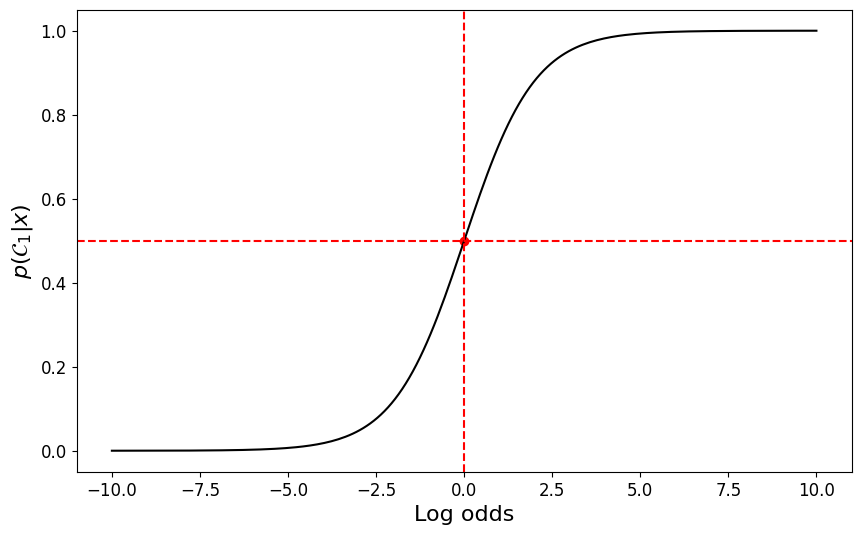

In [2]:
prob = np.linspace(-10, 10, 200)

a_vals = 1 / (1 + np.exp(-prob))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(prob, a_vals, color="black")
ax.scatter(0.0, 0.5, color="red")
ax.axvline(0.0, linestyle="dashed", color="red")
ax.axhline(0.5, linestyle="dashed", color="red")
ax.set_ylabel(r"$p(\mathcal{C}_{1}|x)$", fontsize=16)
ax.set_xlabel("Log odds", fontsize=16)

We see how the sigmoid function is a function lying in $[0,1]$, even as the log odds ratio takes values in $(-\infty,\infty)$. This is necessary since we're interpreting it as a probability.

A particularly important point is where the two classes are equally likely. There, the log odds ratio is 1 and the per class probability is 0.5, as it should. In general, this is selected as the decision boundary.

Two useful properties of the sigmoid function are:

$$\sigma(-a)=1-\sigma(a)$$

and

$$\frac{d\sigma}{da}=\sigma(1-\sigma)$$

For the $K$ class case, we can generalize the sigmoid to the normalized exponential or **softmax** function:

$$p(\mathcal{C}_{k}|x)=\frac{p(x|\mathcal{C}_{k})p(\mathcal{C}_{k})}{\sum_{l=1}^{K}p(x|\mathcal{C}_{l})p(\mathcal{C}_{l})}=\frac{e^{a_{k}}}{\sum_{l=1}^{K}e^{a_{l}}}$$

where $a_{k}=\text{Ln }p(x|\mathcal{C}_{k})p(\mathcal{C}_{k})$

### Logistic Regression

The simplest discriminative classifier is the `Logistic Regressor`. For the two class case, we model the per class probability posterior as

$$p(\mathcal{C}_{1}|\vec{x})=y(\vec{x},\vec{w})=\sigma(\vec{w}^{T}\vec{\phi}(\vec{x}))$$

$$p(\mathcal{C}_{0}|\vec{x})=1-y(\vec{x},\vec{w})=1-\sigma(\vec{w}^{T}\vec{\phi}(\vec{x}))=\sigma(-\vec{w}^{T}\vec{\phi}(\vec{x}))$$

We already have two features of note:

- $\vec{w}^{T}\vec{\phi}(\vec{x})$ acts as the decision function in a discriminant approach. In particular, $\vec{w}^{T}\vec{\phi}(\vec{x})=0$ defines the equi-probability surface.
- The sigmoid is a **non-linear activation function**. This feature, necessary to transform a linear model into a probability estimate, will be very present in `Neural Networks` even for regression for different reasons (the universal approximation is ensured by internal non-linear activation functions between neuron layers).

As in the generalized linear models for regression,  $\vec{\phi}$ includes in principle the bias with $\phi_{0}(\vec{x})=1$.

As with regression, we can group all training pairs into a design matrix

$$\Phi=\begin{pmatrix}\vec{\phi}^{T}(\vec{x}_{1}) \\ ... \\ \vec{\phi}^{T}(\vec{x}_{N})\end{pmatrix}$$

obtaining

$$\sigma(\Phi\cdot \vec{w}) = \begin{pmatrix}\sigma(\vec{\phi}^{T}(\vec{x}_{1}) \cdot\vec{w})\\ ... \\ \sigma(\vec{\phi}^{T}(\vec{x}_{N})\cdot\vec{w})\end{pmatrix}=\begin{pmatrix}\sigma((\vec{w}^{T} \cdot\vec{\phi}(\vec{x}_{1}))^T)\\ ... \\ \sigma((\vec{w}^{T} \cdot\vec{\phi}(\vec{x}_{N}))^T)\end{pmatrix}=\begin{pmatrix}y(\vec{x}_{1},\vec{w})\\ ... \\ y(\vec{x}_{N},\vec{w})\end{pmatrix}$$

Now we need a criteria to obtain the best coefficients $\vec{w}$. As in regression, a natural choice is to maximize the likelhiood (or minmize the negative log-likelihood). For a binary variable, we have only two possible results which we can label as success or failure or heads and tails. Assuming the points are independent and identically distributed, each label has a Bernoulli distribution

$$p(\text{t}|\vec{x},\vec{w})=p(t|\mu)=\mu^{t}(1-\mu)^{1-t}$$

where $\mu=p(\mathcal{C}_{1}|\vec{x})$ is the success probability, which is exactly what we're trying to model!

Thus, for a dataset $\vec{x}_{n}$, with $n=1,..,N$ the likelihood is

$$\mathcal{L}(\vec{w})=p(\text{T}|X,\vec{w})=\prod_{n=1}^{N}y^{t_n}_{n}(1-y_{n})^{1-t_n}$$

where $y_{n}=y(x_{n},\vec{w})$. Again, the logarithm is easier to handle

$$\ln \mathcal{L}(\vec{w})=\sum_{n=1}^{N}(t_{n}\ln y_{n}+(1-t_{n})\ln (1-y_{n}))$$

Again we can define an error by taking the negative log-likelihood. This is called the **binary cross-entropy** (BCE) between $t$ and $y$

$$E(\vec{w})=-\sum_{n=1}^{N}(t_{n}\ln y_{n}+(1-t_{n})\ln (1-y_{n}))$$

We can see how BCE forces the right behaviour into the model:

If $t_{n}=1$, we care about $\ln y_{n}$. Thus, $y_{n}$ needs to be close to 1 to minimize the BCE.

If $t_{n}=0$, we care about $\ln (1-y_{n})$. Thus, $y_{n}$ needs to be close to 0 to minimize the BCE.

Just a reminder, $y_{n}$ is not meant to match $t_{n}$ but $p(t_{n}|\vec{x}_{n},\vec{w})$. Thus, we also seek a degree of confidence to be embedded into the model.


To obtain useful estimates, we need to be able to minimize the BCE with respect to the parameters $\vec{w}$.

For logistic regression, the problem is not as easy as it was for linear regression due to the presence of the logarithms and the sigmoid function. However, we can still solve this numerically. A particularly good choice is the Iterative Reweighted Least Squares or IRLS, which considers a Newton-Ralphson update for step $i$:

$$\vec{w}^{i}=\vec{w}^{i-1}-\mathrm{H}^{-1}\nabla E(\vec{w})|_{\vec{w}^{i-1}}$$

where $\vec{w}^{0}$ is the initialized vector of parameters, $\nabla E(\vec{w})$ is the BCE gradient with respect to the parameters and $\mathrm{H}$ is the Hessian matrix. For a logistic regressor where we combine a linear model with a sigmoide function, this simplifies to a set of **iterative normal equations**:

$$\vec{w}^{i}=\Phi^{T}\mathrm{R}\Phi^{-1}\Phi^{T}\mathrm{R}\mathrm{z}$$

where $\Phi$ is the design matrix, $\mathrm{R}$ a diagonal matrix whose elements are $y_{n}(1-y_{n})$ and $\mathrm{z}$ is

$\mathrm{z}=\Phi\vec{w}^{i-1}-\mathrm{R}^{-1}(\mathrm{Y}-\mathrm{T})$

where $\mathrm{Y}$ e $\mathrm{T}$ are the prediction and label vectors. One should remember that $\mathrm{R}$, $\mathrm{z}$ and $\mathrm{Y}$ are all functions of $\vec{w}^{-1}$.


We could have applied such an algorithm to linear regression, and observed how it converge to the closed solution in 1 step. Additionally, be sure to notice that is an iterative algorithm but it is not sequential since it considers the full dataset at each step.

### Exercise

Let's consider the following dataset

In [3]:
size1 = 250
mu1 = [0, 0]
cov1 = [[1, 0.95], [0.95, 1]]

size2 = 200
mu2 = [-1, 0.5]
cov2 = [[1, 0.8], [0.8, 1]]

np.random.seed(20200922)
# Sample classes
xc1 = np.random.multivariate_normal(mean=mu1, cov=cov1, size=size1).T
xc2 = np.random.multivariate_normal(mean=mu2, cov=cov2, size=size2).T

print(xc1.shape, xc2.shape)

(2, 250) (2, 200)


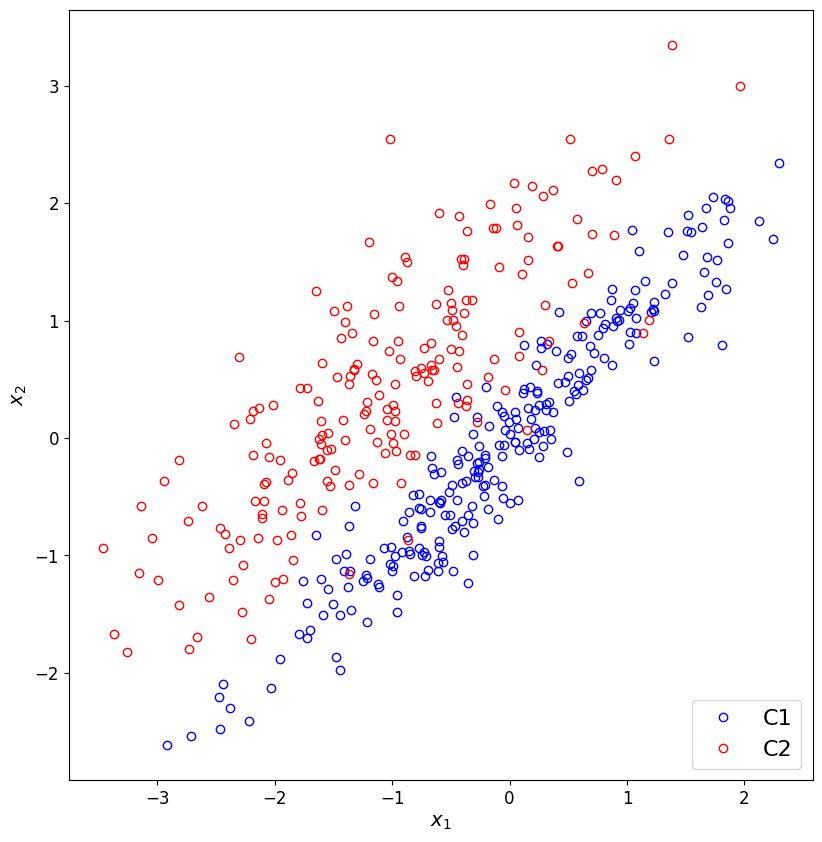

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.plot(*xc1, "ob", mfc="None", label="C1")
ax.plot(*xc2, "or", mfc="None", label="C2")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend(loc="lower right", fontsize=16)
ax.set_aspect("equal")

In [5]:
X = np.hstack([xc1, xc2]).T

tc1 = np.ones(xc1.shape[1])
tc2 = np.zeros(xc2.shape[1])

t = np.concatenate([tc1, tc2]).reshape(-1, 1)

Using this sigmoid function

In [6]:
def sigmoid(logoddsvec):
    return 1 / (1 + np.exp(-logoddsvec))

Train a Logistic Regressor, print the best parameters, compute the predicted probability per measurement and plot it as a function of ($x_1,x_2$).

In [7]:
###SOLUTION_START

Phi = np.hstack([np.ones(len(X)).reshape(-1, 1), X])  # design matrix
# print(Phi.shape)
w = [np.ones(3).reshape(-1, 1)]  # initialize weights
n_iter = 13  # define the number of iterations to play with
for i in range(n_iter):
    try:
        # obtain the initial ys using my weights, the design matrix and the activation function
        y = sigmoid(np.dot(Phi, w[-1]))
        # print(y.shape)
        # R=np.diag(list(map(lambda yy: yy*(1-yy), y[:,0])))#matrix R
        R = np.diag(y[:, 0] * (1 - y[:, 0]))  # matrix R
        # print(R.shape)
        aux_matrix = np.linalg.solve(R, (y - t))  # necessary auxiliar step
        z = np.dot(Phi, w[-1]) - aux_matrix  # matrix z
        aux_matrix_2 = np.dot(np.dot(Phi.T, R), Phi)
        aux_matrix_3 = np.dot(np.dot(Phi.T, R), z)
        w_aux = np.linalg.solve(aux_matrix_2, aux_matrix_3)
        if 1 == 1:  # convergence criterion
            w.append(w_aux)
        else:
            break
    except:
        break

Veamos como evolucionan los coeficientes

In [8]:
for w_val in w:
    print(w_val[:, 0])

[1. 1. 1.]
[ 1.11327092  1.9107308  -4.22815661]
[ 1.98035375  2.70342991 -0.82465731]
[ 1.6519721   2.35792261 -2.97076511]
[ 2.51803921  3.83821506 -4.02416907]
[ 3.27800658  5.28293694 -5.29196333]
[ 3.82769348  6.38715878 -6.31643441]
[ 4.05052504  6.84024367 -6.74704523]
[ 4.07718386  6.89409033 -6.79880813]
[ 4.0775072   6.89473719 -6.79943456]
[ 4.07750725  6.89473728 -6.79943465]
[ 4.07750725  6.89473728 -6.79943465]
[ 4.07750725  6.89473728 -6.79943465]
[ 4.07750725  6.89473728 -6.79943465]


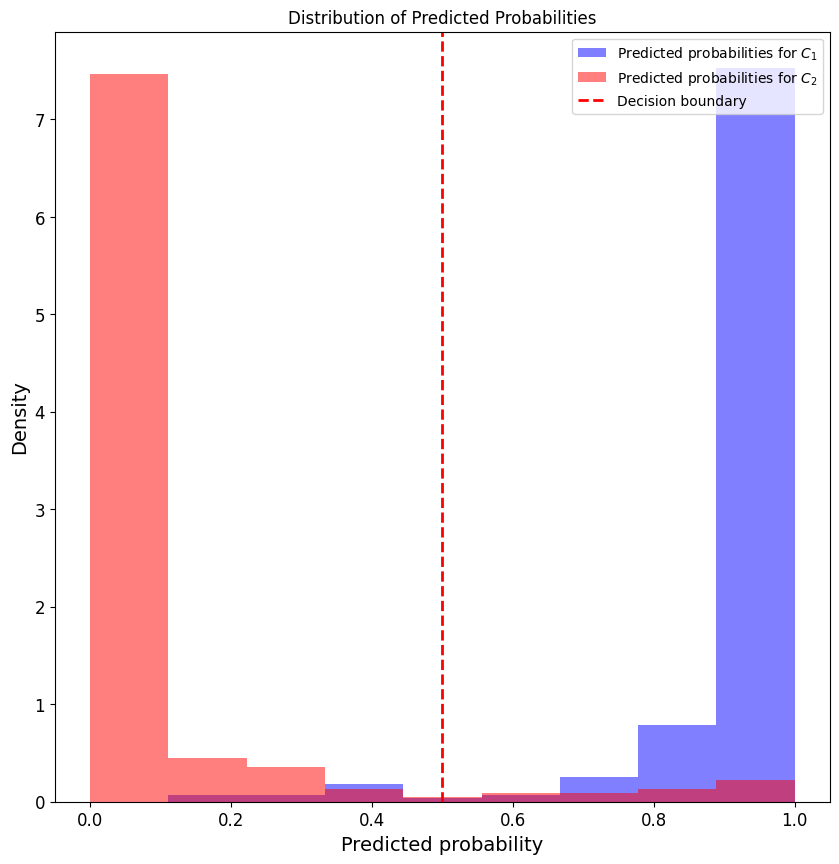

In [9]:
W = w[-1]
y = sigmoid(np.dot(Phi, W))
fig = plt.figure(figsize=(10, 10))
plt.hist(
    y[t[:, 0] > 0.5],
    bins=np.linspace(0, 1, 10),
    density=True,
    alpha=0.5,
    color="blue",
    label="Predicted probabilities for $C_1$",
)
plt.hist(
    y[t[:, 0] <= 0.5],
    bins=np.linspace(0, 1, 10),
    density=True,
    alpha=0.5,
    color="red",
    label="Predicted probabilities for $C_2$",
)
plt.axvline(
    0.5, color="red", linestyle="dashed", linewidth=2, label="Decision boundary"
)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.show()

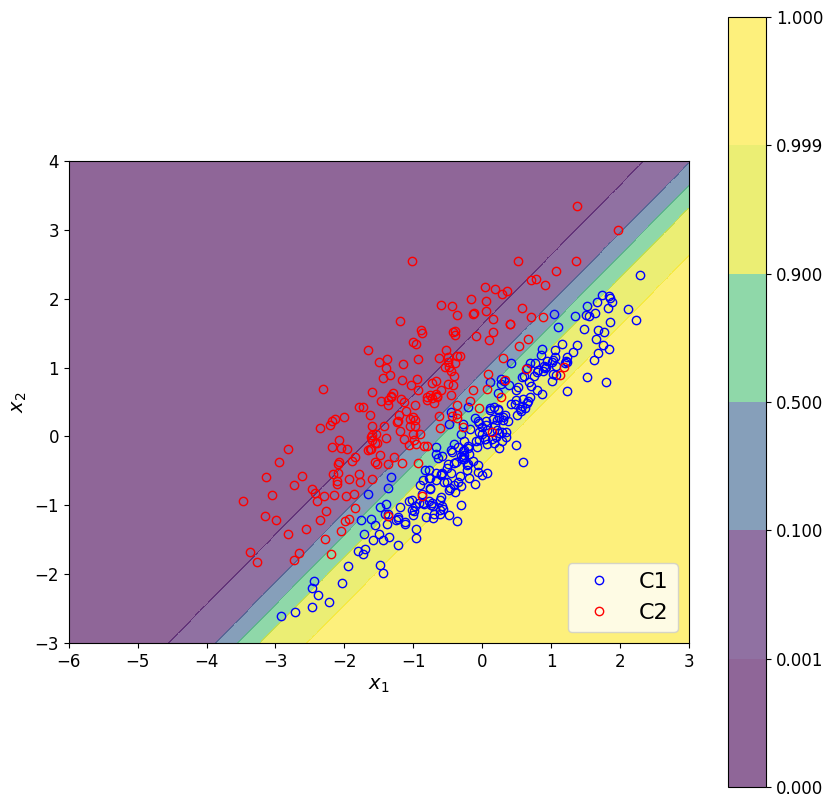

In [10]:
x1 = np.linspace(-6.0, 3.0, 100)
x2 = np.linspace(-3.0, 4.0, 100)
X1toplot, X2toplot = np.meshgrid(x1, x2)
# plt.xlim(0.0,0.2)
# plt.ylim(0.0,0.2)
Z = (
    np.asarray(
        [
            sigmoid(np.dot(W.T, [1.0, el[0], el[1]]))
            for el in np.c_[X1toplot.ravel(), X2toplot.ravel()]
        ]
    )
).reshape(X1toplot.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.plot(*xc1, "ob", mfc="None", label="C1")
ax.plot(*xc2, "or", mfc="None", label="C2")
contour = ax.contourf(
    X1toplot, X2toplot, Z, levels=[0.0, 0.001, 0.1, 0.5, 0.9, 0.999, 1.0], alpha=0.6
)
plt.colorbar(contour, ax=ax)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend(loc="lower right", fontsize=16)
ax.set_aspect("equal")

In [11]:
###SOLUTION_STOP

### Metrics

Once we have a model, we need a criteria for class asignment. For the binary case, a natural choice is to assign $x\in\mathcal{C}_1$ if

$$p(\mathcal{C}_{1}|x)\geq p(\mathcal{C}_{2}|x)$$

Since the two probabilities add up to one, this criteria sets the **decision boundary** at

$$p(\mathcal{C}_{1}|x)=0.5$$

This choice can be shown to maximize the **accuracy** given by

$$\mathrm{Accuracy = }\frac{\mathrm{TP}+\mathrm{TN}}{\mathrm{TP}+\mathrm{FP}+\mathrm{TN}+\mathrm{FN}}$$

where TP, TN, FP and FN stand for True Positive, True Negative, False Positive and False Negative *ie* the fractions of correctly and incorrectly assigned measurements per class (positive is $C_{1}$, negative is $C_{2}$).

That is, we're minimizing the **total misasignments**.

Two other very useful metris are **precision** and **recall**:

$$\mathrm{Precision = }\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}$$

$$\mathrm{Recall = }\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$$

Precision captures how many positive samples are actually positive, and recall relates how many positive samples are we tagging as positives.

All of these can be derived from the **confusion matrix**, which cointains at row, column $(i,j)$ the number of elements belonging to class $i$ that are labelled as belonging class $j$.

In [12]:
def accuracy_score(labels, predictions):
    return np.mean([a == b for a, b in zip(labels, predictions)])


def precision_score(labels, predictions):
    return np.sum([a and b for a, b in zip(labels == 1, predictions == 1)]) / np.sum(
        predictions == 1
    )


def recall_score(labels, predictions):
    return np.sum([a and b for a, b in zip(labels == 1, predictions == 1)]) / np.sum(
        labels == 1
    )

In [13]:
def confusion_matrix(labels, predictions):
    #  pred0 pred1
    # verdad0  VN  FP
    # verdad1  FN  VP
    TP = np.sum(labels[np.where(predictions[:, 0] == 1), 0])
    FP = np.sum(1 - labels[np.where(predictions[:, 0] == 1), 0])
    TN = np.sum(1 - labels[np.where(predictions[:, 0] == 0), 0])
    FN = np.sum(labels[np.where(predictions[:, 0] == 0), 0])
    return np.array([[TN, FP], [FN, TP]])

Let's check them out

In [14]:
# Classify as 1 P(c1 | x) >= 0.5
y_pred = np.where(y >= 0.5, 1, 0)

print(t.shape)

(450, 1)


In [15]:
print(accuracy_score(t, y_pred))  # Accuracy
print(precision_score(t, y_pred))  # Precision
print(recall_score(t, y_pred))  # Recall

0.9533333333333334
0.9525691699604744
0.964


In [16]:
TP = np.sum(t[np.where(y_pred[:, 0] == 1), 0])
FP = np.sum(1 - t[np.where(y_pred[:, 0] == 1), 0])
TN = np.sum(1 - t[np.where(y_pred[:, 0] == 0), 0])
FN = np.sum(t[np.where(y_pred[:, 0] == 0), 0])

print(TP, FP, TN, FN)
print((TP + TN) / (TP + FP + TN + FN))

241.0 12.0 188.0 9.0
0.9533333333333334


In [17]:
cf = confusion_matrix(t, y_pred)
print(cf)

[[188.  12.]
 [  9. 241.]]


In [18]:
TN, FP, FN, TP = cf.ravel()
print(TP, FP, TN, FN)
print((TP + TN) / (TP + FP + TN + FN))  # Accuracy from confusion matrix
print((TP) / (TP + FP))  # Precision from confusion matrix
print((TP) / (TP + FN))  # Recall from confusion matrix

241.0 12.0 188.0 9.0
0.9533333333333334
0.9525691699604744
0.964


All these metrics have been computed after assigning a class label using a particular cut in the predicted class probability $p(C_{1}|\vec{x})>0.5$. 

However, this choice is in some sense arbitrary (although it is the one that minimizes the number of misclassifications). One could be interested in taking different choices, which modifies the different matrixes. For example, a spam filter may prioritize not missing important emails (lowering the false negatives) at the expense of allowing more spam emails to enter (increasing the false positives).


In all cases, there is a relevant **precision/recall trade-off** as we explore the choice of threshold $t$ for class asignment ($y=1$ if $p(C_{1}|\vec{x})>t$).

Intuitevely, low values of $t$ will include more points into the positive sample, increasing both the TP and FP classes. Thus, the recall will increase. However, the precision will decrease. If we increase the threshold, the selection is more stringent and thus the precision will increase. However, the recall will decrease.

/tmp/ipykernel_143904/1362796341.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum([a and b for a, b in zip(labels == 1, predictions == 1)]) / np.sum(


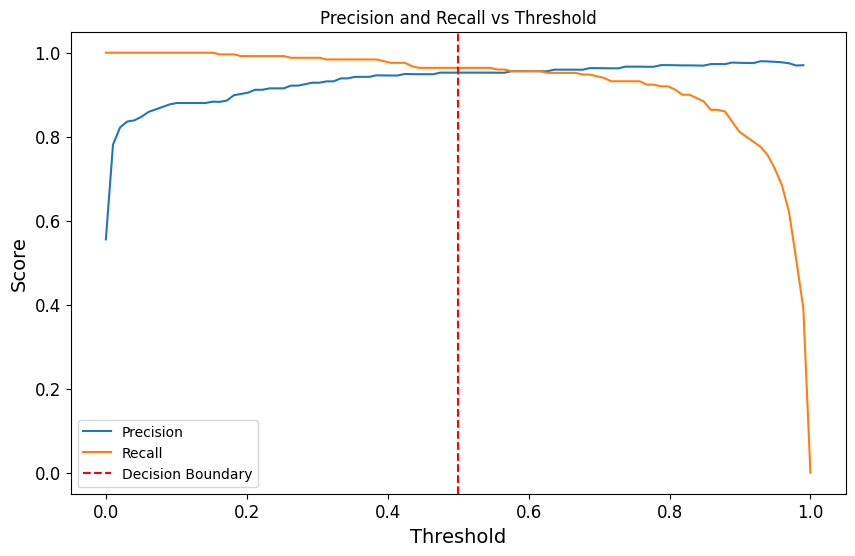

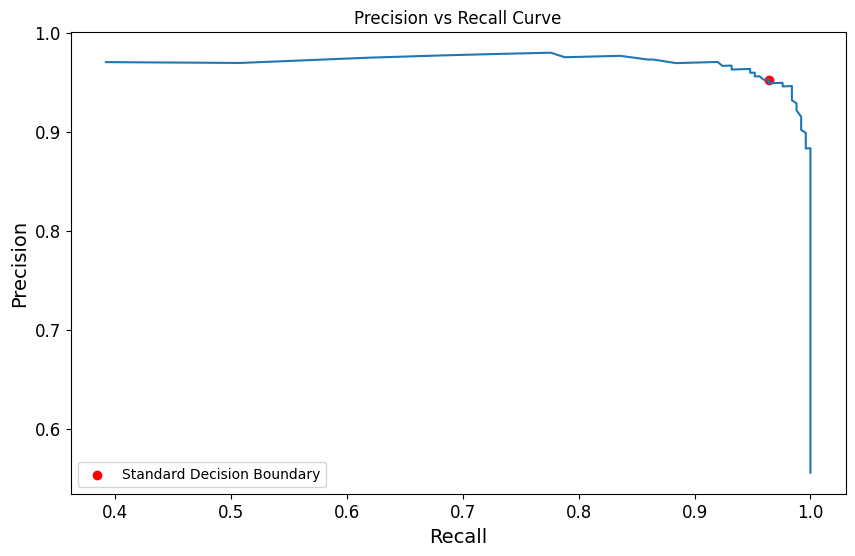

In [19]:
thresholds = np.linspace(0, 1, 100)
precision_values = np.zeros(len(thresholds))
recall_values = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    y_pred = np.where(y[:,0] >= threshold, 1, 0)
    precision_values[i] = precision_score(t[:,0], y_pred)
    recall_values[i] = recall_score(t[:,0], y_pred)
fig = plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_values, label="Precision")
plt.plot(thresholds, recall_values, label="Recall")
plt.axvline(0.5, linestyle="dashed", color="red", label="Decision Boundary")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 6))
plt.plot(recall_values, precision_values)

y_pred = np.where(y[:,0] >= 0.5, 1, 0)
precision_standard = precision_score(t[:,0], y_pred)
recall_standard = recall_score(t[:,0], y_pred)
plt.scatter(recall_standard, precision_standard, color="red", label="Standard Decision Boundary")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall Curve")
plt.legend()
plt.show()


The precision-recall curve allows for a more holistic comparison of classifiers: the more the curve approaches the right-up quadrant, the better the classifier.

However, the most common choice of classifier quantification through curves is not the precision-recall. The most preferred option is the **Receiver Operating Curve or ROC Curve** for short, which plots the True Positive Rate (TPR = TP / (TP + FN) = Recall) as a function of the False Positive Rate (FPR = FP / (FP + TN)) with the threshold implicitly parameterizing the curve.

This choice is made because it cristallizes very clearly the trade-off between correct classification of one class at the expense of incorrect classification of the other. Intuitively, the more the curve approaches the upper-left quadrant, the better the classifier. A quantitative metric derived from the ROC curve is the **Area-Under-Curve (AUC) score**, which is the integral of the ROC Curve. The closer the AUC is to 1, the better the classifier. A random classifier will have a score of 0.5.

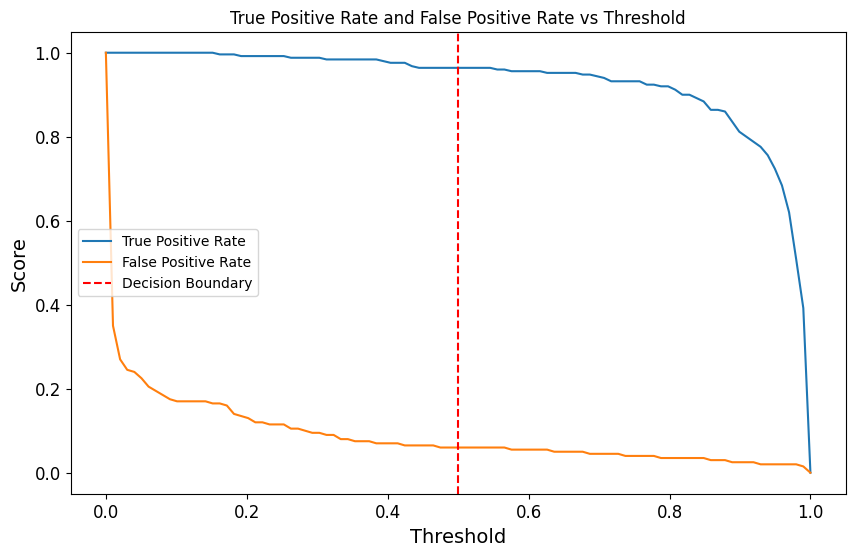

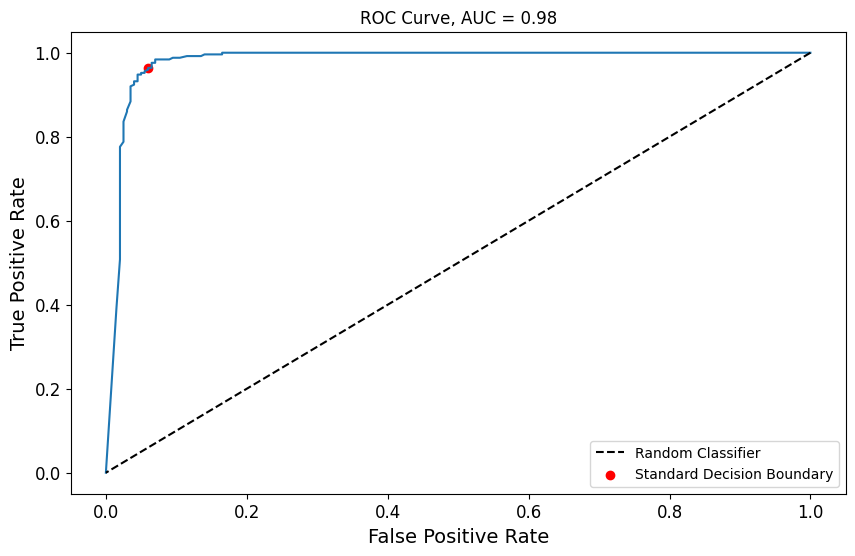

In [20]:
thresholds = np.linspace(0, 1, 100)
tpr_values = np.zeros(len(thresholds))
fpr_values = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    y_pred = np.where(y[:,0] >= threshold, 1, 0)
    TP = np.sum(t[np.where(y_pred == 1), 0])
    FP = np.sum(1 - t[np.where(y_pred == 1), 0])
    TN = np.sum(1 - t[np.where(y_pred == 0), 0])
    FN = np.sum(t[np.where(y_pred == 0), 0])

    tpr_values[i] = TP / (TP + FN)  # True Positive Rate (Recall)
    fpr_values[i] = FP / (FP + TN)  # False Positive Rate (1 - Specificity)
fig = plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr_values, label="True Positive Rate")
plt.plot(thresholds, fpr_values, label="False Positive Rate")
plt.axvline(0.5, linestyle="dashed", color="red", label="Decision Boundary")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("True Positive Rate and False Positive Rate vs Threshold")
plt.legend()
plt.show()

### the minus sign is because the trapezoidal rule integrates from left to right, so we need to flip the sign for the ROC curve
AUC_score = -np.trapz(tpr_values, fpr_values) 
# print(f"AUC Score: {AUC_score}")
fig = plt.figure(figsize=(10, 6))
plt.plot(fpr_values, tpr_values)
plt.plot(fpr_values, fpr_values,color='black', linestyle='dashed', label='Random Classifier')

y_pred = np.where(y[:,0] >= 0.5, 1, 0)
TP = np.sum(t[np.where(y_pred == 1), 0])
FP = np.sum(1 - t[np.where(y_pred == 1), 0])
TN = np.sum(1 - t[np.where(y_pred == 0), 0])
FN = np.sum(t[np.where(y_pred == 0), 0])

tpr_standard = TP / (TP + FN)  # True Positive Rate (Recall)
fpr_standard = FP / (FP + TN)  # False Positive Rate (1 - Specificity)
plt.scatter(fpr_standard, tpr_standard, color="red", label="Standard Decision Boundary")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve, AUC = {:.2f}".format(AUC_score))
plt.legend()
plt.show()

### Exercise

Use `scikit-learn` for a more realistic problem. Explore metrics and the ROC curve.

To do this, make sure to cross-validate using the `cross_val_predict` and `cross_val_score` methods explained in the `regression` notebook.

The new relevant classes are

`sklearn.linear_model.LogisticRegression`

`sklearn.metrics.accuracy_score, sklearn.metrics.precision_score,sklearn.metrics.recall_score, sklearn.metrics.confusion_matrix,sklearn.metrics.precision_recall_curve, sklearn.metrics.roc_curve, sklearn.metrics.roc_auc_score`

You can also explore alternative classifiers

`sklearn.linear_model.Perceptron`

`sklearn.discriminant_analysis.LinearDiscriminantAnalysis`

`sklearn.naive_bayes.GaussianNB`

`sklearn.tree.DecisionTreeClassifier`

`sklearn.ensemble.GradientBoostingClassifier`

`sklearn.ensemble.RandomForestClassifier`

Let me introduce the problem

In [21]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = matplotlib.cm.get_cmap('Spectral')
import pandas as pd
import numpy as np

/tmp/ipykernel_143904/4013479127.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


We take as a simple problem a validation of NBA analytic scores. To do this, we can scrap data from BasketballReference using some nice Python utilities.

In [22]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

Let's use the 2016 season as an example

In [23]:
url = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html".format(2024)# this is the HTML from the given URL
html = urlopen(url)
soup = BeautifulSoup(html)

In [24]:
soup.findAll('tr', limit=2)# use getText()to extract the text we need into a list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]# exclude the first column as we will not need the ranking order from Basketball Reference for the analysis

We can load the data in a `Pandas` dataframe.

In [25]:
headers = headers[1:]
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
stats = pd.DataFrame(player_stats, columns = headers)

For intermediate datasets, pandas is a useful package that allow us to explore the loaded data.

In [26]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Player  951 non-null    object
 1   Age     951 non-null    object
 2   Team    951 non-null    object
 3   Pos     951 non-null    object
 4   G       951 non-null    object
 5   GS      951 non-null    object
 6   MP      951 non-null    object
 7   PER     951 non-null    object
 8   TS%     951 non-null    object
 9   3PAr    951 non-null    object
 10  FTr     951 non-null    object
 11  ORB%    951 non-null    object
 12  DRB%    951 non-null    object
 13  TRB%    951 non-null    object
 14  AST%    951 non-null    object
 15  STL%    951 non-null    object
 16  BLK%    951 non-null    object
 17  TOV%    951 non-null    object
 18  USG%    951 non-null    object
 19  OWS     951 non-null    object
 20  DWS     951 non-null    object
 21  WS      951 non-null    object
 22  WS/48   951 non-null    ob

In [27]:
stats.head()

,Player,Age,Team,Pos,G,GS,MP,PER,TS%,3PAr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards
0,DeMar DeRozan,34,CHI,SF,79,79,2989,19.7,.584,.166,...,25.8,7.0,2.2,9.2,.147,2.1,-0.3,1.8,2.8,CPOY-2
1,Domantas Sabonis,27,SAC,C,82,82,2928,23.2,.637,.081,...,22.2,8.6,4.0,12.6,.206,4.0,2.4,6.5,6.2,"MVP-8,DPOY-10,NBA3"
2,Coby White,23,CHI,PG,79,78,2881,14.5,.570,.460,...,22.7,3.1,1.6,4.7,.078,0.7,-1.3,-0.7,0.9,
3,Mikal Bridges,27,BRK,SF,82,82,2854,14.9,.560,.457,...,24.3,2.1,2.1,4.2,.070,0.7,-1.0,-0.4,1.2,
4,Paolo Banchero,21,ORL,PF,80,80,2799,17.3,.546,.249,...,29.7,1.3,4.0,5.3,.090,1.3,0.0,1.3,2.3,AS


In [28]:
# Let's remove the playoffs
stats=stats[:np.where(stats['Team'] == '')[0][0]]

So, we have a table with players who took part in the 2016 NBA Season.NBA.

Working with real data is complex, and one usually has to do some cleaning. For example, there are players who were traded and played in multiple teams in a single season. This is evidenced by the existence of the `Tot` team assignment.

In [29]:
teams = stats['Team'].unique()# we can see that the team names are not consistent, so we will need to clean them up

teams

array(['CHI', 'SAC', 'BRK', 'ORL', 'PHO', 'ATL', 'MIN', 'DEN', 'NYK',
       'LAL', 'HOU', '2TM', 'TOR', 'IND', 'BOS', 'PHI', 'DAL', 'CHO',
       'MIL', 'OKC', 'LAC', 'CLE', 'GSW', 'MIA', 'WAS', 'NOP', 'SAS',
       'DET', 'MEM', 'UTA', 'POR', '3TM'], dtype=object)

In [30]:
uninteresting_teams = ['2TM', '3TM']# we will eventually remove these teams from the analysis

In [31]:
for team in uninteresting_teams:
    print("Team name and number of players:")
    print(team,np.sum(stats['Team'] == team))

Team name and number of players:
2TM 71
Team name and number of players:
3TM 7


Everything after OWS are advanced stats that talk about "player quality" and are derived from the previous entries (plus maybe some propietary stats.)

Let me define a perhaps interesting problem:

**Can I predict whether a player made the postseason based on his stats?**

The 2016 NBA postseason teams are

In [32]:
no_playoff_west=np.asarray(['GSW','SAC','SAS','UTA','POR','MEM','HOU'])
print(len(no_playoff_west))
playoff_west=np.asarray(['DEN','LAL','OKC','MIN','PHO','LAC','DAL','NOP'])
print(len(playoff_west))

no_playoff_east=np.asarray(['CHI','CHO','ATL','TOR','WAS','BRK','DET'])
print(len(no_playoff_east))
playoff_east=np.asarray(['CLE','MIA','BOS','IND','ORL','MIL','NYK','PHI'])
print(len(playoff_east))

7
8
7
8


### Preprocessing

We could just split our dataframe in train / test (and cross-validate) and play with classifiers. However, we need to preprocess the data a bit before things make sense.

In particular, I only care about players that played meaningful minutes. Otherwise, the data is too noisy.

In [33]:
stats['Pos'].value_counts()

Pos
SG    160
SF    157
PF    153
PG    146
C     119
Name: count, dtype: int64

I'll create a copy of my dataframe and modify that.

In [34]:
stats_now=stats.copy()
stats_now=stats_now[stats_now['Pos'].isin(['SG','PF','PG','C','SF'])]
stats_now["G"]=pd.to_numeric(stats_now["G"])
stats_now["MP"]=pd.to_numeric(stats_now["MP"])
stats_now["USG%"]=pd.to_numeric(stats_now["USG%"])
stats_now=stats_now[stats_now["USG%"]>stats_now["USG%"].mean()]
stats_now["MPperG"]=stats_now["MP"]/stats_now["G"]
stats_now=stats_now[stats_now["G"]>=20]
stats_now=stats_now[stats_now["MPperG"]>=25]
stats_now=stats_now[~stats_now["Team"].isin(uninteresting_teams)]

Let me change the positions to a **numerical embedding**

In [35]:
stats_now=stats_now.replace(['PG','SG','SF','PF','C'],[1,2,3,4,5])
stats_now['Pos'].value_counts()

/tmp/ipykernel_143904/672878979.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stats_now=stats_now.replace(['PG','SG','SF','PF','C'],[1,2,3,4,5])


Pos
2    33
1    32
4    28
3    27
5    17
Name: count, dtype: int64

Now let's label the data with the following code.

0: no playoff west 1: playoff west 2: no playoff east 3: playoff east

label
2    39
3    36
0    33
1    29
Name: count, dtype: int64


/tmp/ipykernel_143904/925194208.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stats_now['label']=stats_now['label'].replace(playoff_east,3)


(array([ 1.,  5., 12.,  0.,  6.,  3.,  0.,  1.,  1.,  1.]),
 array([2. , 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 6.9, 7.6, 8.3, 9. ]),
 <BarContainer object of 10 artists>)

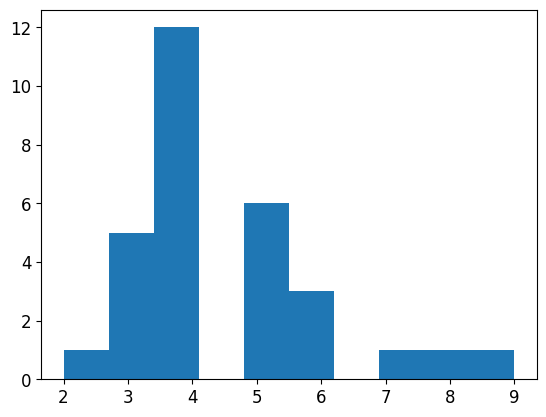

In [36]:
stats_now['label']=stats_now["Team"]
stats_now['label']=stats_now['label'].replace(no_playoff_west,0)
stats_now['label']=stats_now['label'].replace(playoff_west,1)
stats_now['label']=stats_now['label'].replace(no_playoff_east,2)
stats_now['label']=stats_now['label'].replace(playoff_east,3)
print(stats_now['label'].value_counts())
plt.hist(stats_now['Team'].value_counts())

Now let's select some features.

To visualize things, let's keep two for now: PER y USG%. We can store the name, the position and the label.

In [37]:
stats_now=stats_now[['Player','Pos','PER','USG%','label']].copy()
stats_now['PER']=pd.to_numeric(stats_now['PER'])
stats_now['USG%']=pd.to_numeric(stats_now['USG%'])

In [38]:
print(stats_now.iloc[np.where(stats_now["Player"]=="LeBron James")])
print(stats_now.iloc[np.where(stats_now["Player"]=="Nikola Jokic")])

          Player  Pos   PER  USG%  label
31  LeBron James    4  23.7  29.2      1
Empty DataFrame
Columns: [Player, Pos, PER, USG%, label]
Index: []


Do we still have repeated players?

Player
RJ Barrett           2
Terry Rozier         2
Dennis Schröder      2
Pascal Siakam        2
Buddy Hield          2
                    ..
Donte DiVincenzo     1
Tobias Harris        1
Derrick White        1
Brandon Miller       1
Scotty Pippen Jr.    1
Name: count, Length: 132, dtype: int64


(array([127.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

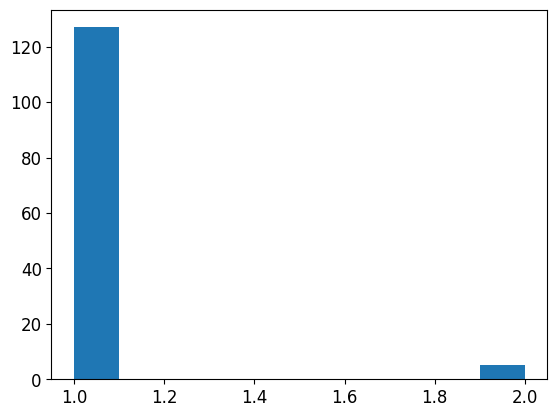

In [39]:
print(stats_now['Player'].value_counts())
plt.hist(stats_now['Player'].value_counts())

Yes, but very few. Let's ignore that now.

Now, we can divide on train and test. Since every position is different (specially back in 2016, the distinction is a bit harder now), we'll **stratify** the splitting so that position proportions are respected.

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(stats_now, stats_now["Pos"]):
    strat_train_set = stats_now.iloc[train_index]
    strat_test_set = stats_now.iloc[test_index]

In [41]:
stats_train = np.array(strat_train_set.drop(["Player","Pos","label"], axis=1)) # drop labels for training set
stats_train_labels = np.array(strat_train_set["label"].copy())
stats_test = np.array(strat_test_set.drop(["Player","Pos","label"], axis=1)) # drop labels for training set
stats_test_labels = np.array(strat_test_set["label"].copy())

In [42]:
stats_train.shape, stats_train_labels.shape, stats_test.shape, stats_test_labels.shape

((109, 2), (109,), (28, 2), (28,))

In [43]:
feat_dict = dict()
feat_dict["PER"] = 0
feat_dict["USG%"] = 1

Let's see how the data looks

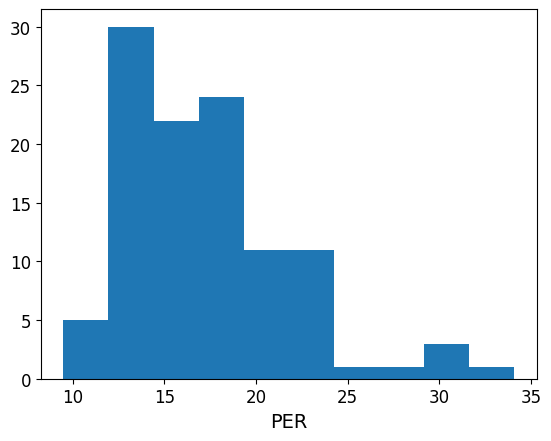

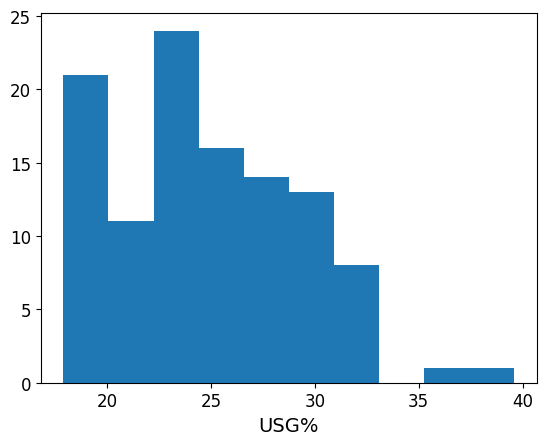

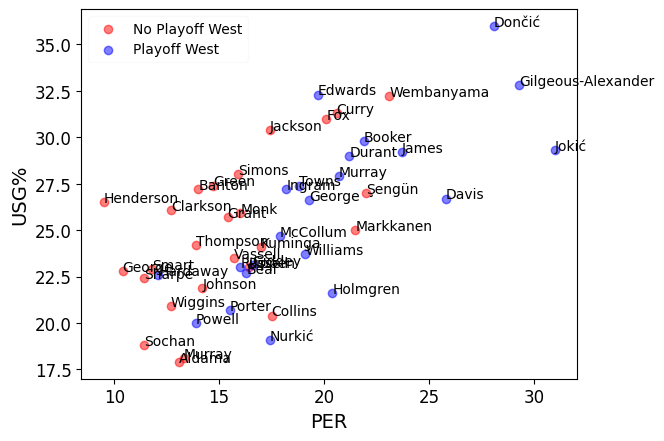

Text(0, 0.5, 'USG%')

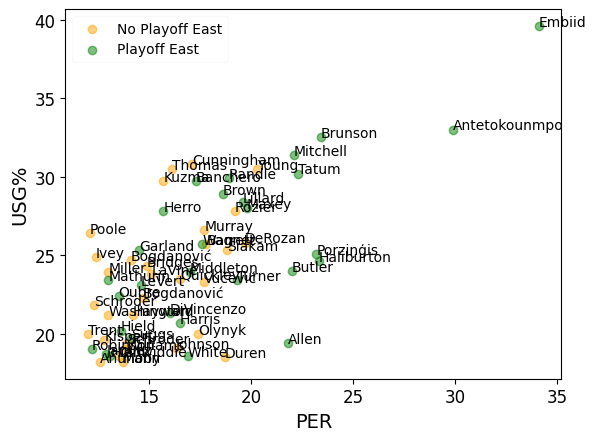

In [44]:
plt.hist(stats_train[:,feat_dict['PER']],bins=10)
plt.xlabel(r'PER')
plt.show()
plt.hist(stats_train[:,feat_dict['USG%']],bins=10)
plt.xlabel(r'USG%')
plt.show()
plt.scatter(stats_train[stats_train_labels==0][:,feat_dict['PER']],stats_train[stats_train_labels==0][:,feat_dict['USG%']], c='red',label="No Playoff West",alpha=0.5)

for i, txt in enumerate(strat_train_set[stats_train_labels==0]['Player']):
    xlabel = stats_train[stats_train_labels==0][:,feat_dict['PER']][i]
    ylabel = stats_train[stats_train_labels==0][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))

plt.scatter(stats_train[stats_train_labels==1][:,feat_dict['PER']],stats_train[stats_train_labels==1][:,feat_dict['USG%']], c='blue', label="Playoff West",alpha=0.5)
for i, txt in enumerate(strat_train_set[stats_train_labels==1]['Player']):
    xlabel = stats_train[stats_train_labels==1][:,feat_dict['PER']][i]
    ylabel = stats_train[stats_train_labels==1][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))

plt.legend(loc='upper left',framealpha =0.1)
# plt.xlim(9.0,31.0)
# plt.ylim(15.0,35.0)
plt.xlabel(r'PER')
plt.ylabel('USG%')
plt.show()


plt.scatter(stats_train[stats_train_labels==2][:,feat_dict['PER']],stats_train[stats_train_labels==2][:,feat_dict['USG%']], c='orange', label="No Playoff East",alpha=0.5)
for i, txt in enumerate(strat_train_set[stats_train_labels==2]['Player']):
    xlabel = stats_train[stats_train_labels==2][:,feat_dict['PER']][i]
    ylabel = stats_train[stats_train_labels==2][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))

plt.scatter(stats_train[stats_train_labels==3][:,feat_dict['PER']],stats_train[stats_train_labels==3][:,feat_dict['USG%']], c='green', label="Playoff East",alpha=0.5)
for i, txt in enumerate(strat_train_set[stats_train_labels==3]['Player']):
    xlabel = stats_train[stats_train_labels==3][:,feat_dict['PER']][i]
    ylabel = stats_train[stats_train_labels==3][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))

plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')
# plt.xlim(9.0,31.0)
# plt.ylim(15.0,35.0)

As a final help, it's usually pretty useful to **scale** the data so that we do not learn differences in arbitrary units. We can do that for continous variables using the `MinMaxScaler` or the `StandardScaler`. The first one simply scales the feature so that it lies in the [0,1] interval, while the latter gaussianizes the data by substracting the mean and scaling by its standard deviation/

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(stats_train)
stats_train_scaled = scaler.transform(stats_train)
stats_test_scaled = scaler.transform(stats_test)

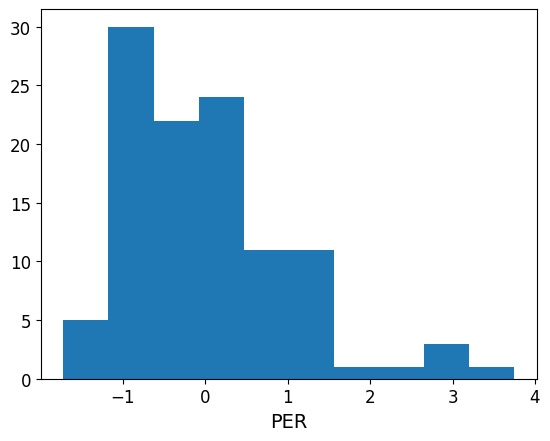

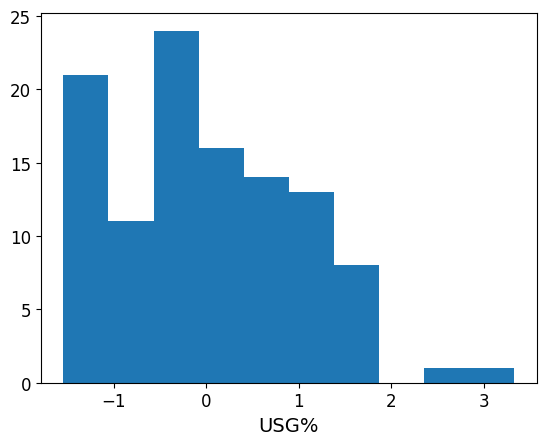

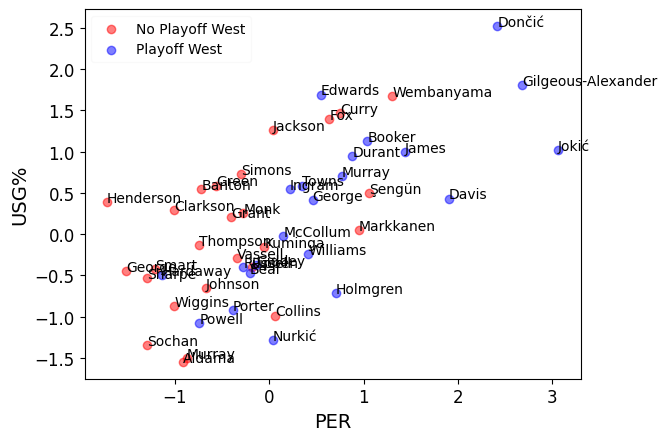

Text(0, 0.5, 'USG%')

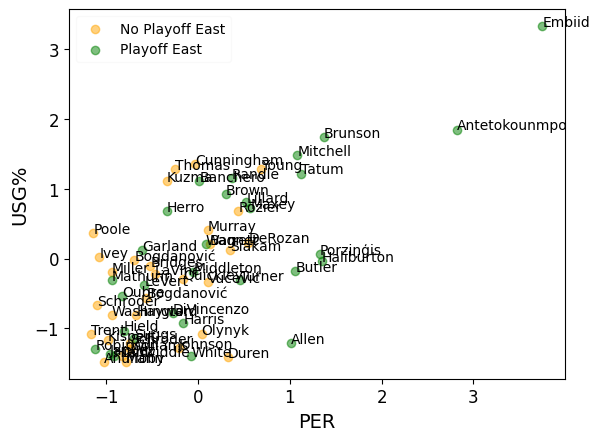

In [46]:
plt.hist(stats_train_scaled[:,feat_dict['PER']],bins=10)
plt.xlabel(r'PER')
plt.show()
plt.hist(stats_train_scaled[:,feat_dict['USG%']],bins=10)
plt.xlabel(r'USG%')
plt.show()

plt.scatter(stats_train_scaled[stats_train_labels==0][:,feat_dict['PER']],stats_train_scaled[stats_train_labels==0][:,feat_dict['USG%']], c='red', label="No Playoff West",alpha=0.5)
for i, txt in enumerate(strat_train_set[stats_train_labels==0]['Player']):
    xlabel = stats_train_scaled[stats_train_labels==0][:,feat_dict['PER']][i]
    ylabel = stats_train_scaled[stats_train_labels==0][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))

plt.scatter(stats_train_scaled[stats_train_labels==1][:,feat_dict['PER']],stats_train_scaled[stats_train_labels==1][:,feat_dict['USG%']], c='blue', label="Playoff West",alpha=0.5)
for i, txt in enumerate(strat_train_set[stats_train_labels==1]['Player']):
    xlabel = stats_train_scaled[stats_train_labels==1][:,feat_dict['PER']][i]
    ylabel = stats_train_scaled[stats_train_labels==1][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))
    
plt.legend(loc='upper left',framealpha =0.1)
# plt.xlim(-3,3.0)
# plt.ylim(-3.0,3.0)
plt.xlabel(r'PER')
plt.ylabel('USG%')
plt.show()

plt.scatter(stats_train_scaled[stats_train_labels==2][:,feat_dict['PER']],stats_train_scaled[stats_train_labels==2][:,feat_dict['USG%']], c='orange', label="No Playoff East",alpha=0.5)
for i, txt in enumerate(strat_train_set[stats_train_labels==2]['Player']):
    xlabel = stats_train_scaled[stats_train_labels==2][:,feat_dict['PER']][i]
    ylabel = stats_train_scaled[stats_train_labels==2][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))

plt.scatter(stats_train_scaled[stats_train_labels==3][:,feat_dict['PER']],stats_train_scaled[stats_train_labels==3][:,feat_dict['USG%']], c='green', label="Playoff East",alpha=0.5)
for i, txt in enumerate(strat_train_set[stats_train_labels==3]['Player']):
    xlabel = stats_train_scaled[stats_train_labels==3][:,feat_dict['PER']][i]
    ylabel = stats_train_scaled[stats_train_labels==3][:,feat_dict['USG%']][i]
    plt.annotate(txt.split(' ')[1], (xlabel, ylabel))

plt.legend(loc='upper left',framealpha =0.1)
plt.xlabel(r'PER')
plt.ylabel('USG%')
# plt.xlim(-3.0,3.0)
# plt.ylim(-3.0,3.0)

Now finally we can define the exercise:

For the west and east playoffs separately, train multiple classifiers. Plot the 2d probability space, explore the metrics and decide which one is the best classifier using cross-validation. Then evaluate the final model on test and report the results.

In [47]:
###SOLUTION_START

###SOLUTION_STOP

You can repeat this using more inputs:

label
2    39
3    36
0    33
1    29
Name: count, dtype: int64


/tmp/ipykernel_143904/3707084008.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stats_now=stats_now.replace(['PG','SG','SF','PF','C'],[1,2,3,4,5])
/tmp/ipykernel_143904/3707084008.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stats_now['label']=stats_now['label'].replace(playoff_east,3)


(array([ 1.,  5., 12.,  0.,  6.,  3.,  0.,  1.,  1.,  1.]),
 array([2. , 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 6.9, 7.6, 8.3, 9. ]),
 <BarContainer object of 10 artists>)

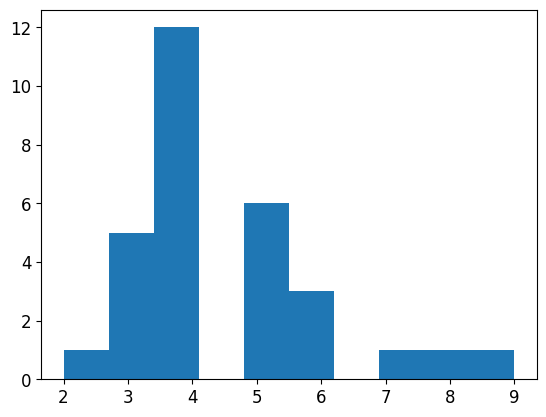

In [48]:
stats_now=stats.copy()
stats_now=stats_now[stats_now['Pos'].isin(['SG','PF','PG','C','SF'])]
stats_now["G"]=pd.to_numeric(stats_now["G"])
stats_now["MP"]=pd.to_numeric(stats_now["MP"])
stats_now["USG%"]=pd.to_numeric(stats_now["USG%"])
stats_now=stats_now[stats_now["USG%"]>stats_now["USG%"].mean()]
stats_now["MPperG"]=stats_now["MP"]/stats_now["G"]
stats_now=stats_now[stats_now["G"]>=20]
stats_now=stats_now[stats_now["MPperG"]>=25]
stats_now=stats_now[~stats_now["Team"].isin(uninteresting_teams)]

stats_now=stats_now.replace(['PG','SG','SF','PF','C'],[1,2,3,4,5])
stats_now['Pos'].value_counts()

stats_now['label']=stats_now["Team"]
stats_now['label']=stats_now['label'].replace(no_playoff_west,0)
stats_now['label']=stats_now['label'].replace(playoff_west,1)
stats_now['label']=stats_now['label'].replace(no_playoff_east,2)
stats_now['label']=stats_now['label'].replace(playoff_east,3)
print(stats_now['label'].value_counts())
plt.hist(stats_now['Team'].value_counts())

In [49]:
stats_now=stats_now[['Player','Pos','PER','USG%','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','label']]
for e in ['PER','USG%','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%']:
  stats_now[e]=pd.to_numeric(stats_now[e])

In [50]:
###SOLUTION_START

###SOLUTION_STOP

### Multiclass (`sklearn`-based)

We already mentioned how the binary case needs to be extended to the multiclass case.

However, the multiclass may be subtle due to ambiguities in the class asignment procedure. Let's see why.

For the binary case

- We have labels, which are usually written as {0,1},{-1,1},{[1,0],[0,1]}. As an example, `sklearn` usually takes the first convention. In any self-written implementation care should be taken when loading the labels.
- We have predictions. For the binary case we only need to specify one number. This number could be a discriminant function $y$ (as in a Perceptron or a Support Vector Classifier) or a probability  $p(C_{1}|x)$ (Logistic Regression, Naive Bayes). We thus only need to learn a **single function which defines all decision boundaries**.

Let's use a toy dataset from `sklearn`:

In [51]:
from sklearn.datasets import make_blobs

gt_center = np.array([[2.0, 2.0], [-2.0, -2.0]])
X, t = make_blobs(
    1000,
    n_features=2,
    centers=gt_center,
    cluster_std=1.5,
    random_state=1234,
)

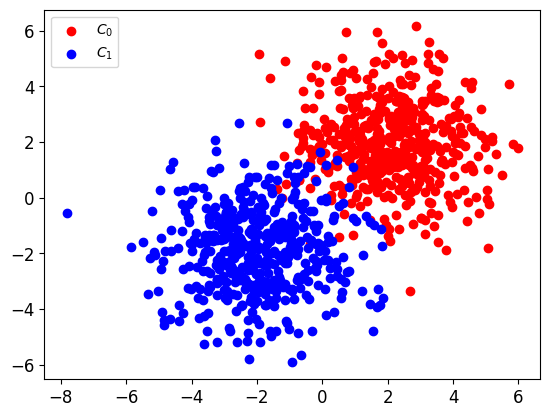

In [52]:
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.legend(loc="upper left")

We can train a discriminant function and a discriminative model:

In [53]:
from sklearn.linear_model import LogisticRegression, Perceptron

lr = LogisticRegression()
percep = Perceptron()

In [54]:
lr.fit(X, t)
percep.fit(X, t)

Perceptron()

For the Perceptron case, we have a single decision function, where the usual criteria is that we label a datapoint as positive if $y\geq0$. This can be modified to explore different precision/recall trade-offs.

In [55]:
print(percep.decision_function(X[:1]))

[4.95109495]


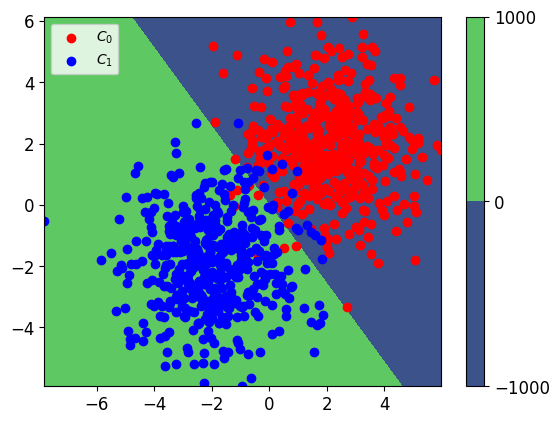

In [56]:
x1vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2vals = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X1, X2 = np.meshgrid(x1vals, x2vals)
Xvals = np.array([X1.ravel(), X2.ravel()]).T
Z = percep.decision_function(Xvals).reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[-1000, 0.0, 1000])
plt.colorbar()
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.legend(loc="upper left")

For the logistic regressor, we have two probabilities which add to 1. We can then only store the second column outputted by `sklearn`. The default criteria is to assign as positives all datapoints that have $p(C_{1}|x)\geq 0.5$.

In [57]:
print(lr.predict_proba(X[:1]))

[[0.06546735 0.93453265]]


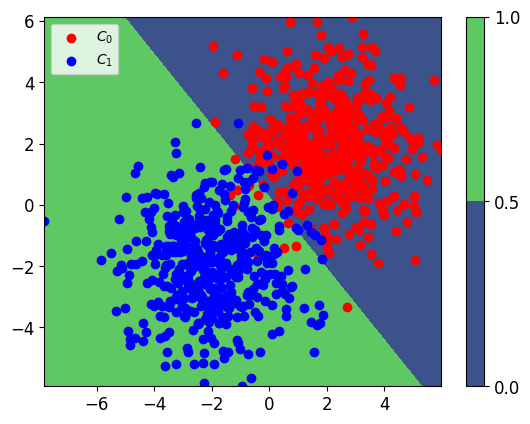

In [58]:
x1vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2vals = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X1, X2 = np.meshgrid(x1vals, x2vals)
Xvals = np.array([X1.ravel(), X2.ravel()]).T
Z = lr.predict_proba(Xvals)[:, 1].reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0.0, 0.5, 1.0])
plt.colorbar()
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.legend(loc="upper left")

Now let's go the to the multiclass case:

- We have the labels, which are essentially written in two ways: {0,1,...,K-1} or {[1,0,...,0],[0,1,0,...,0],...} (which is called the one-in-K representation).  `sklearn` can use the first one and adapt it internally even if the second one is preferred algorithmically. Again, hand-written implementations need to be careful.
- We have the predictions. Here is where the big difference between binary and multiclass appears. How do we decide on assignments? It depends on the algorithm, which may choose among three possibilities:
1. One-vs-Remainder / One-vs-All: For each class $k$ we train a classifier that distinguishes between that class and the rest. We have then $K$ classifiers which need to be combined. For example, for 4 classes we have: (0,123), (1,023), (2,013), (3,012). A class asignment is found by interesecting the different classifier regions. This introduces the possibility of ambiguous choices. Even more, usually one runs into very imbalanced classifiers.
2. One-vs-one: Here we train a classifier for each combination of two classes, obtaining  $\frac{K(K-1)}{2}$ classifiers in total. For 4 classes we have: (0,1), (0,2), (0,3), (1,2), (1,3), (2,3). A class assigned by majority vote, which also introduces ambiguities.
3. The third approach, which doesn't have ambiguities, is to train a single classifier that predicts among the $K$ classes. For a discriminative function-based classifier, this is achieved by learning K functions $y_{k}$ at the same time and assigning a class by finding the maximum $y_{k}$ among all $K$ functions. The decision boundaries appear when any pair of functions coincide $y_{k}=y_{k'}$. This criteria is unambiguous. For discriminative and generative models, this is actually the easiest approach. We just need to learn  $p(C_{k}|x)$ as detailed before.

Why do we need to use criteria 1 or 2? Some algorithms cannot use the third approach. 

Let's go back to a toy dataset:

In [59]:
from sklearn.datasets import make_blobs

gt_center = np.array([[3.0, 3.0], [-3.0, -3.0], [-3.0, 3.0], [3.0, -3.0]])
X, t = make_blobs(
    1000,
    n_features=2,
    centers=gt_center,
    cluster_std=1.0,
    random_state=1234,
)

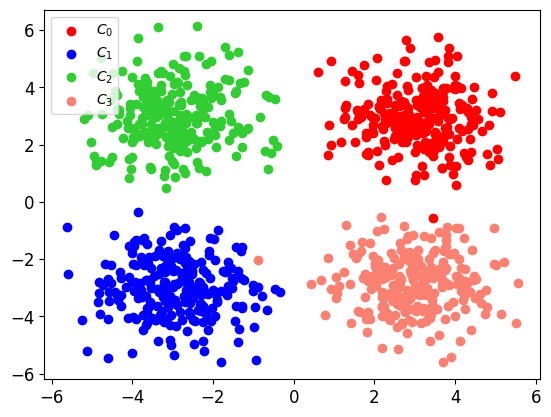

In [60]:
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.scatter(X[t == 2, 0], X[t == 2, 1], c="limegreen", label="$C_{2}$")
plt.scatter(X[t == 3, 0], X[t == 3, 1], c="salmon", label="$C_{3}$")

plt.legend(loc="upper left")

Let's see how a discriminant function and a discriminative model look:

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lr = LogisticRegression()
lda = LinearDiscriminantAnalysis(solver="lsqr")

In [62]:
lr.fit(X, t)
lda.fit(X, t)

LinearDiscriminantAnalysis(solver='lsqr')

Now LDA has four decision functions:

In [63]:
print(lda.decision_function(X[:1]))

[[ -3.13427549 -18.79619805  -8.21778037 -11.90111461]]


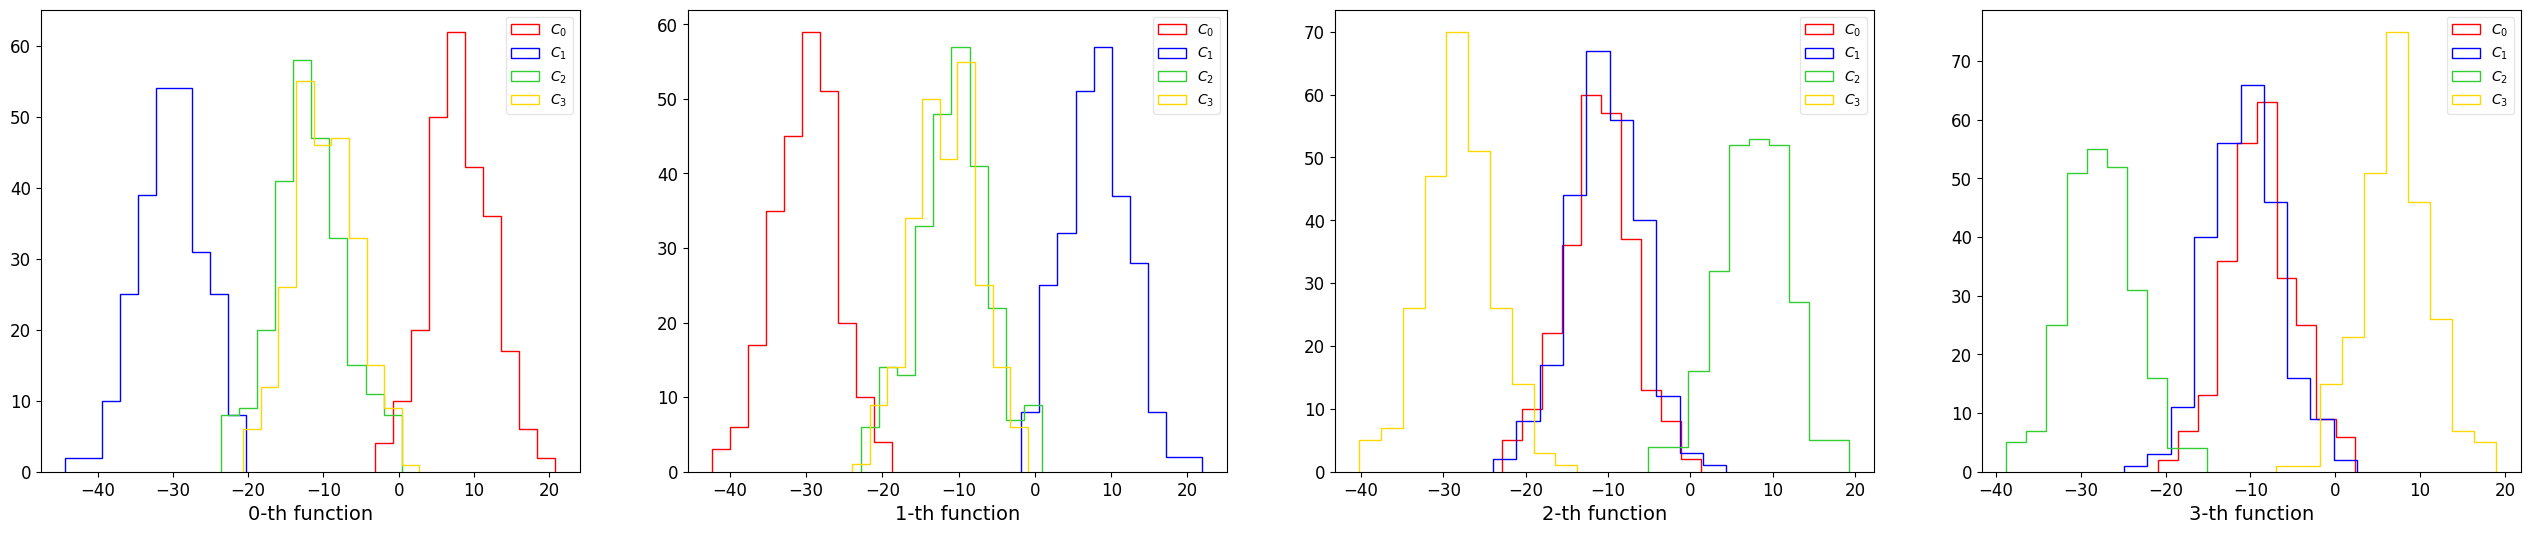

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(4 * 2 * 4, 2 * 3))
for k in range(4):
    ax[k].hist(
        lda.decision_function(X)[t == 0, k],
        histtype="step",
        color="red",
        label="$C_{0}$",
    )
    ax[k].hist(
        lda.decision_function(X)[t == 1, k],
        histtype="step",
        color="blue",
        label="$C_{1}$",
    )
    ax[k].hist(
        lda.decision_function(X)[t == 2, k],
        histtype="step",
        color="limegreen",
        label="$C_{2}$",
    )
    ax[k].hist(
        lda.decision_function(X)[t == 3, k],
        histtype="step",
        color="gold",
        label="$C_{3}$",
    )
    ax[k].set_xlabel(str(k) + "-th function")
    ax[k].legend(loc="upper right", framealpha=0.5)

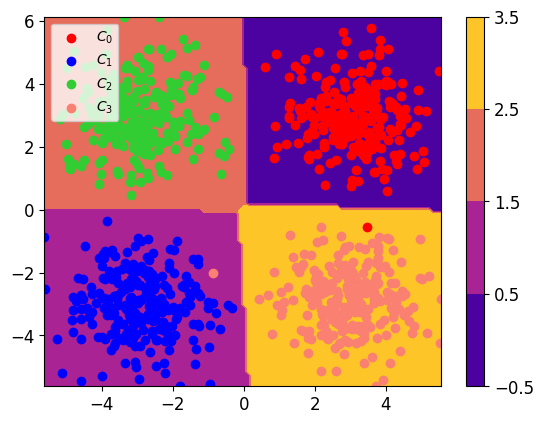

In [65]:
x1vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2vals = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X1, X2 = np.meshgrid(x1vals, x2vals)
Xvals = np.array([X1.ravel(), X2.ravel()]).T
Z = np.argmax(lda.decision_function(Xvals), axis=1).reshape(X1.shape)
plt.contourf(X1, X2, Z, cmap="plasma", levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
plt.colorbar()
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.scatter(X[t == 2, 0], X[t == 2, 1], c="limegreen", label="$C_{2}$")
plt.scatter(X[t == 3, 0], X[t == 3, 1], c="salmon", label="$C_{3}$")
plt.legend(loc="upper left")

While for the Logistic Regressor we have four probabilities that add up to one:

In [66]:
print(lr.predict_proba(X[:1]))

[[8.74153292e-01 1.20848126e-04 1.11017989e-01 1.47078710e-02]]


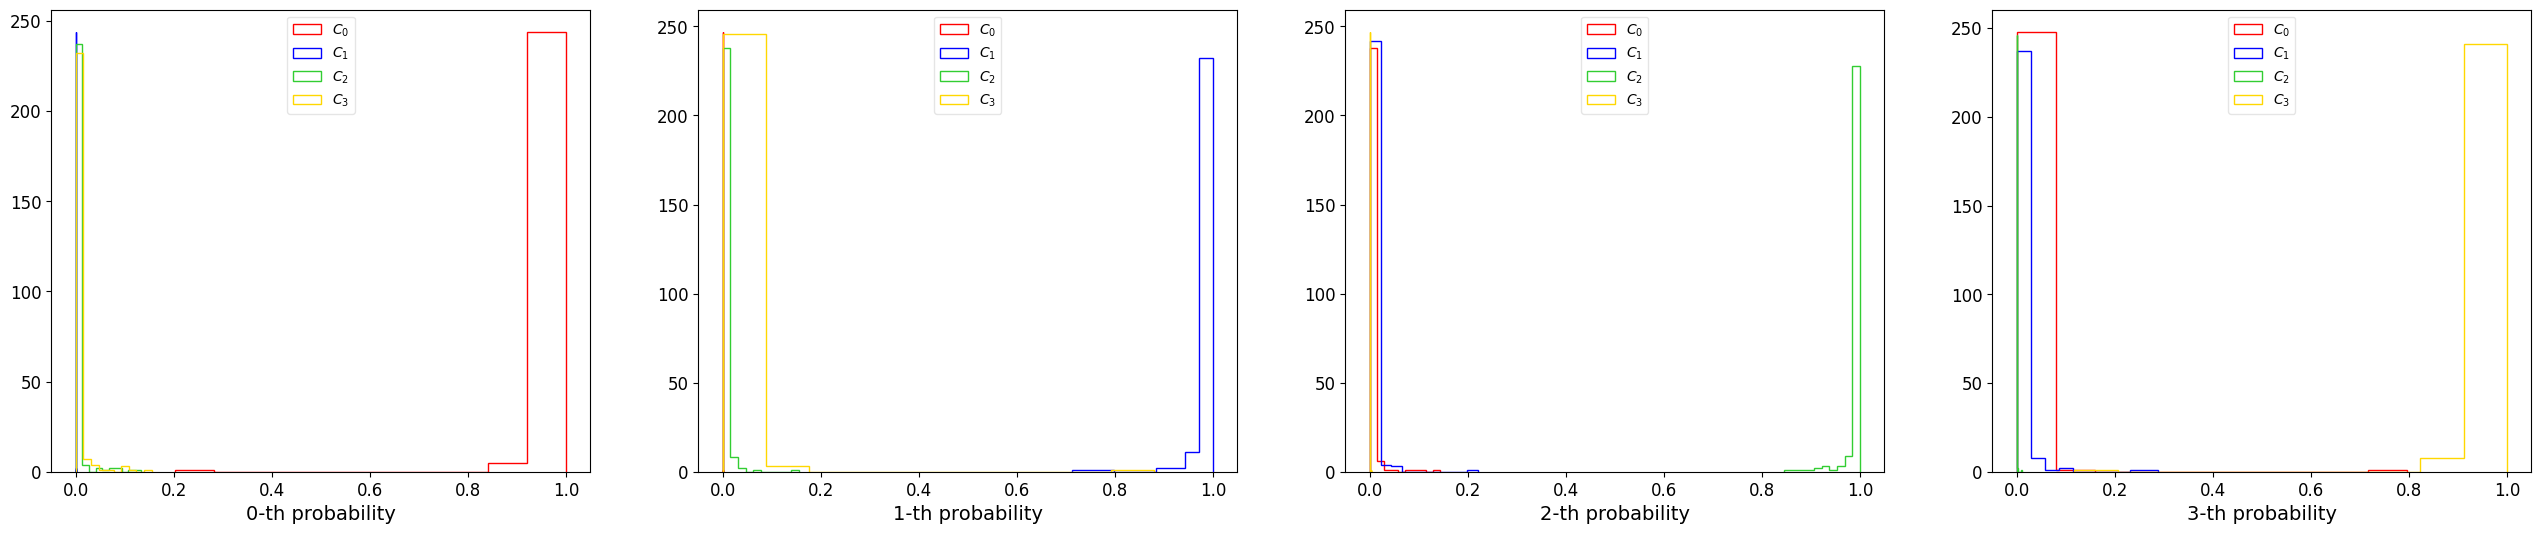

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(4 * 2 * 4, 2 * 3))
for k in range(4):
    ax[k].hist(
        lr.predict_proba(X)[t == 0, k], histtype="step", color="red", label="$C_{0}$"
    )
    ax[k].hist(
        lr.predict_proba(X)[t == 1, k], histtype="step", color="blue", label="$C_{1}$"
    )
    ax[k].hist(
        lr.predict_proba(X)[t == 2, k],
        histtype="step",
        color="limegreen",
        label="$C_{2}$",
    )
    ax[k].hist(
        lr.predict_proba(X)[t == 3, k], histtype="step", color="gold", label="$C_{3}$"
    )
    ax[k].set_xlabel(str(k) + "-th probability")
    ax[k].legend(loc="upper center", framealpha=0.5)

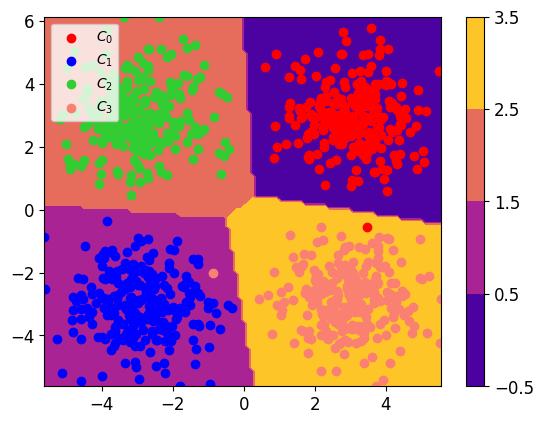

In [68]:
x1vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2vals = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X1, X2 = np.meshgrid(x1vals, x2vals)
Xvals = np.array([X1.ravel(), X2.ravel()]).T
Z = np.argmax(lr.predict_proba(Xvals), axis=1).reshape(X1.shape)
plt.contourf(X1, X2, Z, cmap="plasma", levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
plt.colorbar()
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.scatter(X[t == 2, 0], X[t == 2, 1], c="limegreen", label="$C_{2}$")
plt.scatter(X[t == 3, 0], X[t == 3, 1], c="salmon", label="$C_{3}$")
plt.legend(loc="upper left")

Let's focus on algorithms that follow the third approach (this is going to be the case for Neural Networks for example). We can still compute the accuracy and the confusion matrix

In [69]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(t, lr.predict(X)))
print(accuracy_score(t, lr.predict(X)))

[[249   0   0   1]
 [  0 250   0   0]
 [  0   0 250   0]
 [  0   1   0 249]]
0.998


Other metrics have the issue of being designed for the binary case. We can always binarize the problem and train a series of binary classifiers. Another possibility is to take the classifier and binarize the labels after training. The only issue is how to re-define the threshold in this case. Because the threshold looks at relative values between per-class probabilities, it is not trivial how to explore the precision-recall trade-off with a simple parameterization.

In [70]:
from sklearn.metrics import precision_score, f1_score

for k in range(4):
    print("Class " + str(k) + " against the remainder")
    print(f1_score(np.where(t == k, 1.0, 0.0), np.where(lr.predict(X) == k, 1.0, 0.0)))

Class 0 against the remainder
0.9979959919839679
Class 1 against the remainder
0.998003992015968
Class 2 against the remainder
1.0
Class 3 against the remainder
0.996


The `Perceptron` and the `SVC` classifiers are not trivial to extend to the multiclass case. The former uses the One-vs-Remainder criteria. The latter has two possibilities:
- `LinearSVC` considers the One-vs-Remainder criteria. It can however use the `crammer_singer` criteria which approximates the third possibility detailed above.
- `SVC` uses the One-vs-One approach. However, and due to compatibility, it outputs the decision function as if it was One-vs-Reaminder. It can be morphed into One-vs-One with a simple option.

In [71]:
from sklearn.svm import LinearSVC, SVC

lsvc_1 = LinearSVC(loss="hinge", penalty="l2", C=10.0, max_iter=1000)
svc_1 = SVC(kernel="linear", C=10.0, decision_function_shape="ovr")
svc_2 = SVC(kernel="linear", C=10.0, decision_function_shape="ovo")

In [72]:
lsvc_1.fit(X, t)
svc_1.fit(X, t)
svc_2.fit(X, t)

/home/mszewc/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/mszewc/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC(C=10.0, decision_function_shape='ovo', kernel='linear')

In [73]:
print(lsvc_1.decision_function(X[:1]).shape)
print(svc_1.decision_function(X[:1]).shape)
print(svc_2.decision_function(X[:1]).shape)

(1, 4)
(1, 4)
(1, 6)


Because we are using a linear kernel (`kernel=linear`), we can see the coefficients:

In [74]:
print(lsvc_1.coef_.shape)  # (nclasses, ncoefs)
print(svc_1.coef_.shape)  # (nclasses*(nclasses-1)/2, ncoefs)
print(svc_2.coef_.shape)  # (nclasses*(nclasses-1)/2, ncoefs)

(4, 2)
(6, 2)
(6, 2)


The shape of the decision function, does not change how `SVC` learns. It is always One-vs-One.The ordering is from 0 to K-1 with “0 vs 1”, “0 vs 2” , … “0 vs K-1”, “1 vs 2”, “1 vs 3”, “1 vs K-1”, . . . “K-2 vs K-1”

In [75]:
print(np.allclose(svc_1.coef_, svc_2.coef_))

True


In [76]:
print(lsvc_1.decision_function(X[:1]), len(lsvc_1.decision_function(X[:1])[0]))
print(lsvc_1.predict(X[:1]))
print(svc_1.decision_function(X[:1]), len(svc_1.decision_function(X[:1])[0]))
print(svc_1.predict(X[:1]))
print(svc_2.decision_function(X[:1]), len(svc_2.decision_function(X[:1])[0]))
print(svc_2.predict(X[:1]))

[[ -1.82838649 -11.66072849  -3.4851467   -5.50617296]] 4
[0]
[[ 3.26875807 -0.31485508  2.28228002  1.29340438]] 4
[0]
[[  1.00000237   0.99979827   2.16213468  -5.73964319 -10.29957355
    0.78927807]] 6
[0]


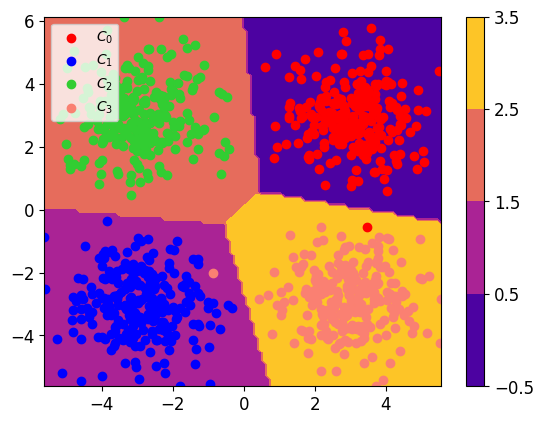

In [77]:
x1vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2vals = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X1, X2 = np.meshgrid(x1vals, x2vals)
Xvals = np.array([X1.ravel(), X2.ravel()]).T
Z = lsvc_1.predict(Xvals).reshape(X1.shape)
plt.contourf(X1, X2, Z, cmap="plasma", levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
plt.colorbar()
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.scatter(X[t == 2, 0], X[t == 2, 1], c="limegreen", label="$C_{2}$")
plt.scatter(X[t == 3, 0], X[t == 3, 1], c="salmon", label="$C_{3}$")
plt.legend(loc="upper left")

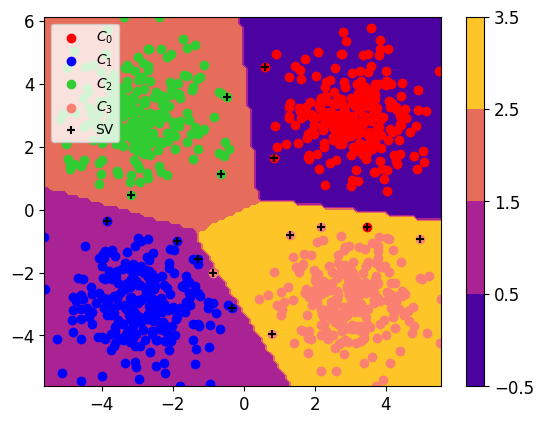

In [78]:
x1vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2vals = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X1, X2 = np.meshgrid(x1vals, x2vals)
Xvals = np.array([X1.ravel(), X2.ravel()]).T
Z = svc_1.predict(Xvals).reshape(X1.shape)
plt.contourf(X1, X2, Z, cmap="plasma", levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
plt.colorbar()
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.scatter(X[t == 2, 0], X[t == 2, 1], c="limegreen", label="$C_{2}$")
plt.scatter(X[t == 3, 0], X[t == 3, 1], c="salmon", label="$C_{3}$")
plt.scatter(
    svc_1.support_vectors_[:, 0],
    svc_1.support_vectors_[:, 1],
    marker="+",
    color="black",
    label="SV",
)
plt.legend(loc="upper left")

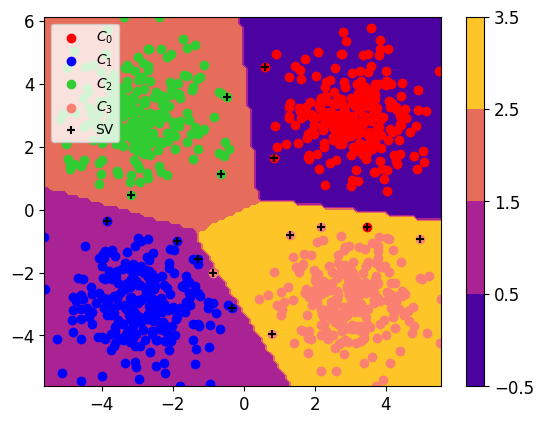

In [79]:
x1vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x2vals = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X1, X2 = np.meshgrid(x1vals, x2vals)
Xvals = np.array([X1.ravel(), X2.ravel()]).T
Z = svc_2.predict(Xvals).reshape(X1.shape)
plt.contourf(X1, X2, Z, cmap="plasma", levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
plt.colorbar()
plt.scatter(X[t == 0, 0], X[t == 0, 1], c="red", label="$C_{0}$")
plt.scatter(X[t == 1, 0], X[t == 1, 1], c="blue", label="$C_{1}$")
plt.scatter(X[t == 2, 0], X[t == 2, 1], c="limegreen", label="$C_{2}$")
plt.scatter(X[t == 3, 0], X[t == 3, 1], c="salmon", label="$C_{3}$")
plt.scatter(
    svc_2.support_vectors_[:, 0],
    svc_2.support_vectors_[:, 1],
    marker="+",
    color="black",
    label="SV",
)

plt.legend(loc="upper left")

### Exercise

Let's do the famous MNIST dataset (we could also do the IRIS).

Train a classifier on the full set of 10 labels, and compute all possible metrics. Decide which numbers are easy to distinguish and which are hard.

The MNIST dataset is a classic ML benchmark. It consists of 70 000 small images containing hand-written digits. The "target" is the number they're supposed to be.

This dataset is so common that `sklearn` has a function to download them. Check the specific function for the `sklearn` version you have. We can borrow some code to order the dataset

In [80]:
### from Geron
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target.loc[:60000-1])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target.loc[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data.loc[reorder_train]
    mnist.target[:60000] = mnist.target.loc[reorder_train]
    mnist.data[60000:] = mnist.data.loc[reorder_test + 60000]
    mnist.target[60000:] = mnist.target.loc[reorder_test + 60000]

In [81]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

/tmp/ipykernel_143904/3214717252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnist.data[:60000] = mnist.data.loc[reorder_train]
/tmp/ipykernel_143904/3214717252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mnist.data[:60000] = mnist.data.loc[reorder_train]
/tmp/ipykernel_143904/3214717252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

We have a `data` and `target` attribute

In [82]:
print(mnist.data.shape)
print(mnist.target.shape)

(70000, 784)
(70000,)


The images have 784 features, each corresponding to a pixel of the 28 x 28 image. The feature values are in the [0,255] range where 0 is white and 255 is black.

In [83]:
X, t = np.array(mnist["data"]), np.array(mnist["target"])

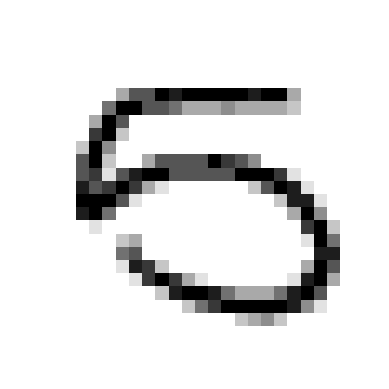

In [84]:
# Let's select a random digit to visualize.
a_digit = X[35735]

# we can reshape the digit to 28x28 pixels, and plot it
a_digit_image = a_digit.reshape(28, 28)
plt.imshow(a_digit_image, cmap = mpl.cm.binary,
           interpolation="None")
plt.axis("off")
plt.show()

When training a classifier, it is useful to scale the features. Remember that.

In [85]:
###SOLUTION_START
###SOLUTION_STOP